# 공유폴더에 접근하기






In [1]:
# 구글 드라이브 마운트

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip /content/drive/MyDrive/dataset/Covid_Dataset_.zip

In [4]:
root_dir = '/content/Covid_Dataset/'

# 데이터 준비 및 전처리

**COVID-CT-Dataset: A CT Image Dataset about COVID-19**

[Original data source](https://github.com/UCSD-AI4H/COVID-CT)

[Related paper](https://arxiv.org/pdf/2003.13865.pdf)

### 이미지 예시 출력

In [5]:
import random
import os
import cv2
import matplotlib.pyplot as plt

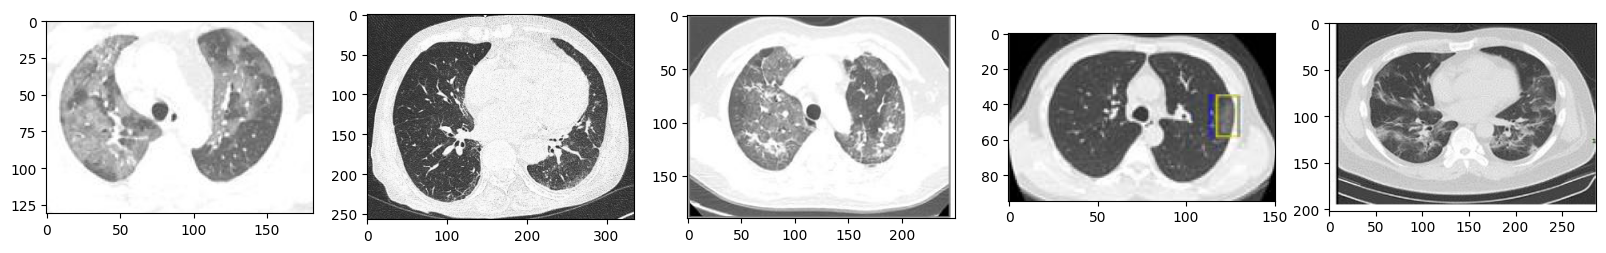

In [9]:
# Train data의 COVID 데이터 랜덤하게 5개 확인하기

covid_train_path = os.path.join(root_dir, 'Covid_Train', '1_CT_COVID')

covid_files      = [os.path.join(covid_train_path, x) for x in os.listdir(covid_train_path)]
covid_images    =  [cv2.imread(x) for x in random.sample(covid_files, 5)]

plt.figure(figsize=(20,10))
columns = 5
for i, image in enumerate(covid_images):
    plt.subplot((len(covid_images) + columns - 1) // columns, columns, i + 1)
    plt.imshow(image)

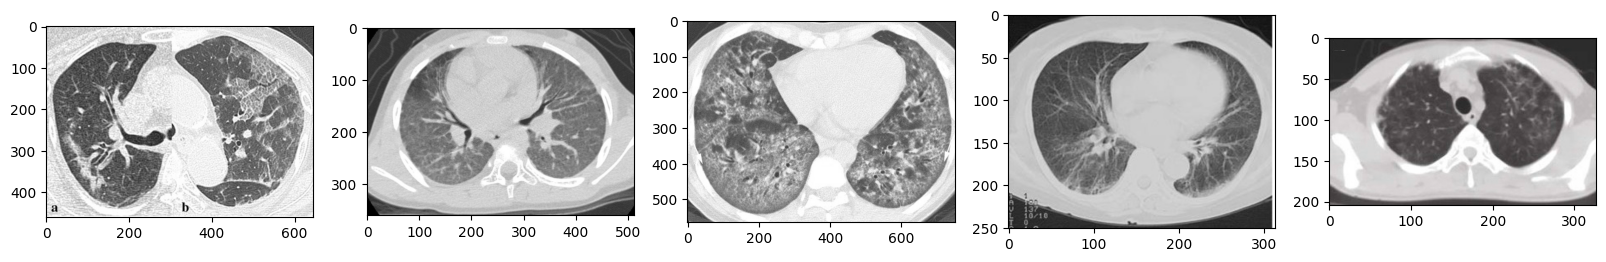

In [11]:
# Train data의 Non-COVID 데이터 랜덤하게 5개 확인하기

covid_train_path = os.path.join(root_dir, 'Covid_Train', '0_CT_NonCOVID')

covid_files      = [os.path.join(covid_train_path, x) for x in os.listdir(covid_train_path)]
covid_images    =  [cv2.imread(x) for x in random.sample(covid_files, 5)]

plt.figure(figsize=(20,10))
columns = 5
for i, image in enumerate(covid_images):
    plt.subplot((len(covid_images) + columns - 1) // columns, columns, i + 1)
    plt.imshow(image)

### 데이터 분포 확인

In [12]:
import os

In [13]:
def print_files_in_dir(root_dir, prefix):
    files = os.listdir(root_dir)
    lab = ['COVID', "Non-COVID"]
    for i, file in enumerate(files):
        path = os.path.join(root_dir, file)
        file_list = os.listdir(path)
        print(f"{prefix} 데이터의 {lab[i]} 수: {len(file_list)}")

        # print(f"해당 폴더의 데이터의 수 {len(file_list)}")

In [14]:
phase = "Train"
print_files_in_dir(root_dir + f"Covid_{phase}", phase)
print()
phase = "Valid"
print_files_in_dir(root_dir + f"Covid_{phase}", phase)
print()
phase = "Test"
print_files_in_dir(root_dir + f"Covid_{phase}", phase)

Train 데이터의 COVID 수: 191
Train 데이터의 Non-COVID 수: 234

Valid 데이터의 COVID 수: 60
Valid 데이터의 Non-COVID 수: 58

Test 데이터의 COVID 수: 98
Test 데이터의 Non-COVID 수: 105


### 데이터 전처리

In [15]:
# 필요한 모듈 불러오기

import numpy as np
import torch
from torchvision import datasets, transforms
import torch.utils.data as data

In [17]:
# 디바이스 설정 (GPU 사용 가능하면 GPU 사용하도록)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

random_seed = 2024

torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)

np.random.seed(random_seed)
random.seed(random_seed)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [18]:
# 데이터 transform 적용하기

normalize = transforms.Normalize(mean=[0,0,0], std=[1,1,1])
image_transforms = {
    'train': transforms.Compose([
    transforms.Resize(256),

    # data augmentation
    # Overfitting을 방지하기 위한 step 1 ~ training set에만 적용
    transforms.RandomResizedCrop((224),scale=(0.5,1.0)),
    transforms.RandomHorizontalFlip(),

    transforms.ToTensor(),
    # Overfitting을 방지하기 위한 step 2
    normalize
    ]),

    'valid': transforms.Compose([
    # 224 X 224는 CNN 모델에서 자주 받는 input size
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    normalize
    ])
}

In [19]:
train_dataset_folder = root_dir + 'Covid_Train'
val_dataset_folder = root_dir + 'Covid_Valid'
test_dataset_folder = root_dir + 'Covid_Test'

In [20]:
train_dataset = datasets.ImageFolder(root=train_dataset_folder, transform=image_transforms['train'])
valid_dataset = datasets.ImageFolder(root=val_dataset_folder, transform=image_transforms['valid'])
test_dataset = datasets.ImageFolder(root=test_dataset_folder, transform=image_transforms['valid'])

In [21]:
# DataLoader을 위한 hyperparameter 설정

train_params = {
    'batch_size': 64,
    'shuffle': True,
    'num_workers': 1,
    'drop_last': False}

valid_params = {
    'batch_size': 64,
    'shuffle': False,
    'num_workers': 1,
    'drop_last': False}

In [22]:
train_loader = data.DataLoader(train_dataset, **train_params)
valid_loader = data.DataLoader(valid_dataset, **valid_params)
test_loader = data.DataLoader(test_dataset, **valid_params)

In [23]:
# Train DataLoader 데이터 확인해보기

for x, y in train_loader:
    print(x.shape)
    print(y.shape)
    break

torch.Size([64, 3, 224, 224])
torch.Size([64])


In [24]:
# Valid DataLoader 데이터 확인해보기

for x, y in valid_loader:
    print(x.shape)
    print(y.shape)
    break

torch.Size([64, 3, 224, 224])
torch.Size([64])


# 모델 만들기

In [25]:
from torchvision import models
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [27]:
# 모델 설정 값

config = {
    # Classfier 설정
    # MLP의 Layer를 쌓고 싶을 때, "cls_hidden_dims" : [1024,512,256]
    "cls_hidden_dims" : [1024, 512, 256]
    }

In [28]:
class CovidResNet(nn.Module):
    """pretrain 된 ResNet을 이용해 CT image embedding
    """

    def __init__(self):
        """
		Args:
			base_model : resnet18 / resnet50
			config: 모델 설정 값
		"""
        super(CovidResNet, self).__init__()

        model = models.resnet50(pretrained=True)
        num_ftrs = model.fc.in_features
        self.num_ftrs = num_ftrs

        """
        param.requires_grad = False 는 모델에 대해서 fine-tuning하지 않겠다는 것을 의미
        이 블럭을 주석처리하거나 False로 만들어야 한다.
        현재같이 데이터가 적은 상황에서는 fine-tuning이 불리하므로 사용하지 않음
        """
        for name, param in model.named_parameters():
            if 'layer2' in name:
                break
            param.requires_grad = False

        self.features = nn.Sequential(*list(model.children())[:-1])

    def forward(self, x):
        x = self.features(x)
        b = x.size(0)
        x = x.view(b, -1)

        return x


## Model 선택 가능

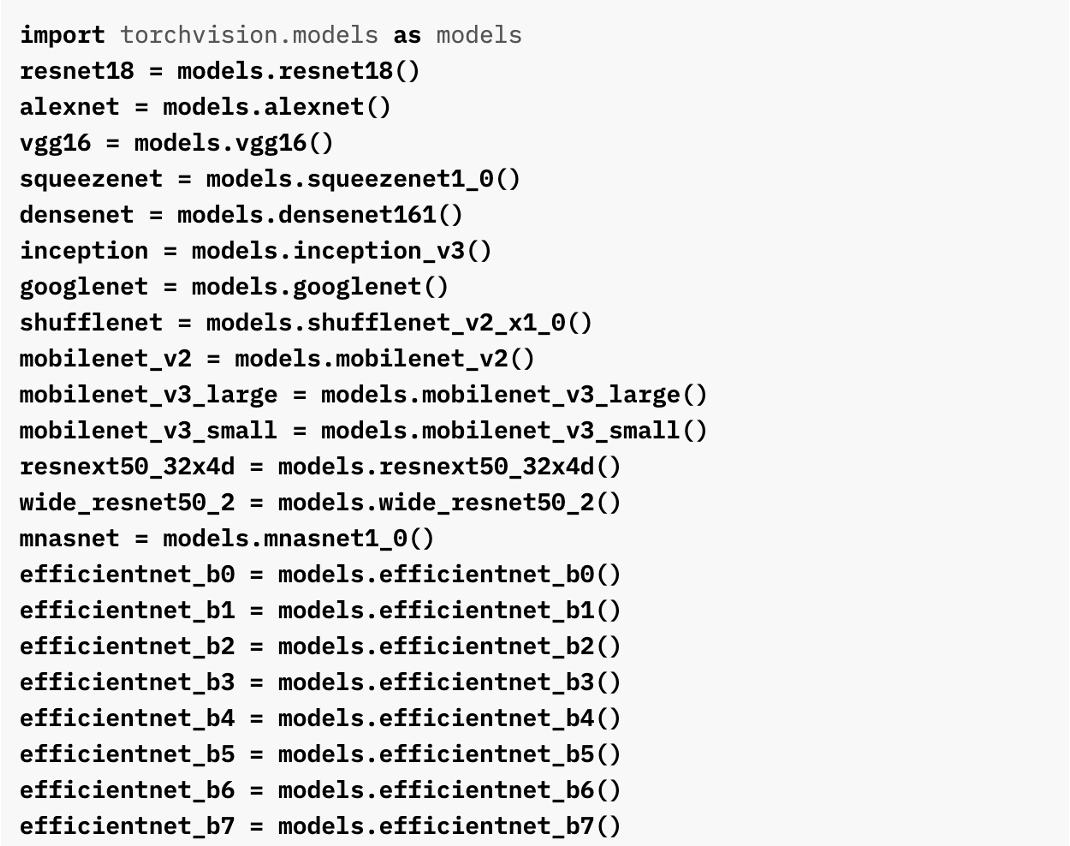

In [29]:
model_image = CovidResNet()
model_image

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 144MB/s]


CovidResNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d

In [30]:
class Classifier(nn.Sequential):
    """임베딩 된 feature를 이용해 classificaion
    """
    def __init__(self, model_image, **config):
        """
        Args:
            model_image : image emedding 모델
            config: 모델 설정 값
        """
        super(Classifier, self).__init__()

        self.model_image = model_image # image 임베딩 모델

        self.input_dim = model_image.num_ftrs # image feature 사이즈
        self.dropout = nn.Dropout(0.1) # dropout 적용

        self.hidden_dims = config['cls_hidden_dims'] # classifier hidden dimensions
        layer_size = len(self.hidden_dims) + 1 # hidden layer 개수
        dims = [self.input_dim] + self.hidden_dims + [2]

        self.predictor = nn.ModuleList([nn.Linear(dims[i], dims[i+1]) for i in range(layer_size)]) # classifer layers

    def forward(self, v):
        # Drug/protein 임베딩
        v_i = self.model_image(v) # batch_size x hidden_dim

        for i, l in enumerate(self.predictor):
            if i == (len(self.predictor)-1):
                # If last layer,
                v_i = l(v_i)
            else:
                # If Not last layer, dropout과 ReLU 적용
                v_i = F.relu(self.dropout(l(v_i)))

        return v_i


In [31]:
model = Classifier(model_image, **config)
model

Classifier(
  (model_image): CovidResNet(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True

# 모델 학습 (Model training)

### 모델 학습을 위한 설정

In [32]:
# 학습에 필요한 변수 설정

# 학습 진행에 필요한 hyperparameter

learning_rate = 0.0001
train_epoch   = 20

In [33]:
# optimizer

opt     = torch.optim.Adam(model.parameters(), lr = learning_rate)
loss_fn = torch.nn.CrossEntropyLoss()

In [34]:

import copy
from prettytable import PrettyTable
from time import time
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix

### 모델 학습 진횅

In [35]:
loss_history_train = []
loss_history_val = []

max_acc = 0

# 모델 GPU 메모리에 올리기
model = model.to(device)

# Best 모델 초기화
model_best = copy.deepcopy(model)

# 결과 정리를 위한 PrettyTable
valid_metric_record = []
valid_metric_header = ["# epoch"]
valid_metric_header.extend(["Accuracy", "sensitivity", "specificity", "roc_score"])
table = PrettyTable(valid_metric_header)

float2str = lambda x:'%0.4f'%x # float 소숫점 4자리까지만 str로 바꾸기

# 학습 진행
print('--- Go for Training ---')
# 학습 시작 시간 기록
t_start = time()

for epo in range(train_epoch):
    # Model training
    model.train()

    # Mini-batch 학습
    for i, (v_i, label) in enumerate(train_loader):
        # input data gpu에 올리기
        v_i = v_i.float().to(device)
        # forward-pass
        output = model(v_i)

        # 미리 정의한 손실함수(MSE)로 손실(loss) 계산
        loss = loss_fn(output, label.to(device))

        # 각 iteration 마다 loss 기록
        loss_history_train.append(loss.item())

        # gradient 초기화
        opt.zero_grad()
        # back propagation
        loss.backward()
        # parameter update
        opt.step()

    # gradient tracking X
    with torch.set_grad_enabled(False):

        y_pred = []
        y_score = []
        y_label = []
        # model validation
        model.eval()

        for i, (v_i, label) in enumerate(valid_loader):
            # validation 입력 데이터 gpu에 올리기
            v_i = v_i.float().to(device)

            # forward-pass
            output = model(v_i)

            # 미리 정의한 손실함수(MSE)로 손실(loss) 계산
            loss = loss_fn(output, label.to(device))

            # 각 iteration 마다 loss 기록
            loss_history_val.append(loss.item())

            pred = output.argmax(dim=1, keepdim=True)
            score = nn.Softmax(dim = 1)(output)[:,1]

            # 예측값, 참값 cpu로 옮기고 numpy 형으로 변환
            pred = pred.cpu().numpy()
            score = score.cpu().numpy()
            label = label.cpu().numpy()

            # 예측값, 참값 기록하기
            y_label = y_label + label.flatten().tolist()
            y_pred = y_pred + pred.flatten().tolist()
            y_score = y_score + score.flatten().tolist()

    # metric 계산
    classification_metrics = classification_report(y_label, y_pred,
                        target_names = ['CT_NonCOVID', 'CT_COVID'],
                        output_dict= True)

    # sensitivity is the recall of the positive class
    sensitivity = classification_metrics['CT_COVID']['recall']
    # specificity is the recall of the negative class
    specificity = classification_metrics['CT_NonCOVID']['recall']
    # accuracy
    accuracy = classification_metrics['accuracy']
    # confusion matrix
    conf_matrix = confusion_matrix(y_label, y_pred)
    # roc score
    roc_score = roc_auc_score(y_label, y_score)

    # 계산한 metric 합치기
    lst = ["epoch " + str(epo)] + list(map(float2str,[accuracy, sensitivity, specificity, roc_score]))

    # 각 epoch 마다 결과값 pretty table에 기록
    table.add_row(lst)
    valid_metric_record.append(lst)

    # mse 기준으로 best model 업데이트
    if accuracy > max_acc:
        # best model deepcopy
        model_best = copy.deepcopy(model)
        # max MSE 업데이트
        max_acc = accuracy

    # 각 epoch 마다 결과 출력
    print('Validation at Epoch '+ str(epo + 1) + ' , Accuracy: ' + str(accuracy)[:7] + ' , sensitivity: '\
						 + str(sensitivity)[:7] + ', specificity: ' + str(f"{specificity}") +' , roc_score: '+str(roc_score)[:7])


--- Go for Training ---
Validation at Epoch 1 , Accuracy: 0.55932 , sensitivity: 0.15, specificity: 0.9827586206896551 , roc_score: 0.58936
Validation at Epoch 2 , Accuracy: 0.58474 , sensitivity: 0.33333, specificity: 0.8448275862068966 , roc_score: 0.73390
Validation at Epoch 3 , Accuracy: 0.66101 , sensitivity: 0.53333, specificity: 0.7931034482758621 , roc_score: 0.8
Validation at Epoch 4 , Accuracy: 0.61016 , sensitivity: 0.26666, specificity: 0.9655172413793104 , roc_score: 0.77758
Validation at Epoch 5 , Accuracy: 0.66949 , sensitivity: 0.41666, specificity: 0.9310344827586207 , roc_score: 0.83247
Validation at Epoch 6 , Accuracy: 0.65254 , sensitivity: 0.35, specificity: 0.9655172413793104 , roc_score: 0.83620
Validation at Epoch 7 , Accuracy: 0.75423 , sensitivity: 0.63333, specificity: 0.8793103448275862 , roc_score: 0.85919
Validation at Epoch 8 , Accuracy: 0.71186 , sensitivity: 0.8, specificity: 0.6206896551724138 , roc_score: 0.82557
Validation at Epoch 9 , Accuracy: 0.72

# 모델 테스트 (model testing)

In [36]:
# Test dataloader 확인
for i, (v_i, label) in enumerate(test_loader):
    print(v_i.shape)
    print(label.shape)
    break

torch.Size([64, 3, 224, 224])
torch.Size([64])


### 모델 테스트 진행

In [37]:
# 테스트 진행

model = model_best

y_pred = []
y_label = []
y_score = []

model.eval()
for i, (v_i, label) in enumerate(test_loader):
    # input data gpu에 올리기
    v_i = v_i.float().to(device)

    with torch.set_grad_enabled(False):
        # forward-pass
        output = model(v_i)

        # 미리 정의한 손실함수(MSE)로 손실(loss) 계산
        loss = loss_fn(output, label.to(device))

        # 각 iteration 마다 loss 기록
        loss_history_val.append(loss.item())

        pred = output.argmax(dim=1, keepdim=True)
        score = nn.Softmax(dim = 1)(output)[:,1]

        # 예측값, 참값 cpu로 옮기고 numpy 형으로 변환
        pred = pred.cpu().numpy()
        score = score.cpu().numpy()
        label = label.cpu().numpy()

    # 예측값, 참값 기록하기
    y_label = y_label + label.flatten().tolist()
    y_pred = y_pred + pred.flatten().tolist()
    y_score = y_score + score.flatten().tolist()

# metric 계산
classification_metrics = classification_report(y_label, y_pred,
                    target_names = ['CT_NonCOVID', 'CT_COVID'],
                    output_dict= True)
# sensitivity is the recall of the positive class
sensitivity = classification_metrics['CT_COVID']['recall']
# specificity is the recall of the negative class
specificity = classification_metrics['CT_NonCOVID']['recall']
# accuracy
accuracy = classification_metrics['accuracy']
# confusion matrix
conf_matrix = confusion_matrix(y_label, y_pred)
# roc score
roc_score = roc_auc_score(y_label, y_score)

# 각 epoch 마다 결과 출력
print('Validation at Epoch '+ str(epo + 1) + ' , Accuracy: ' + str(accuracy)[:7] + ' , sensitivity: '\
                        + str(sensitivity)[:7] + ' specificity: ' + str(f"{specificity}") +' , roc_score: '+str(roc_score)[:7])


Validation at Epoch 20 , Accuracy: 0.83743 , sensitivity: 0.77551 specificity: 0.8952380952380953 , roc_score: 0.89173


### 테스트 결과 시각화

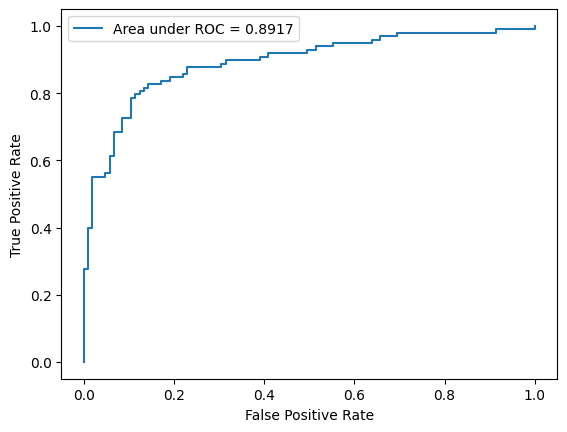

In [38]:
# plot the roc curve
fpr, tpr, _ = roc_curve(y_label, y_score)
plt.plot(fpr, tpr, label = "Area under ROC = {:.4f}".format(roc_score))
plt.legend(loc = 'best')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

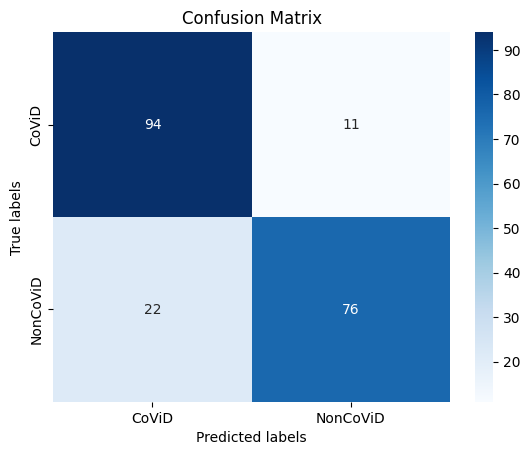

In [39]:
import seaborn as sns

conf_matrix = conf_matrix
ax= plt.subplot()
sns.heatmap(conf_matrix, annot=True, ax = ax, cmap = 'Blues'); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(['CoViD', 'NonCoViD']); ax.yaxis.set_ticklabels(['CoViD', 'NonCoViD']);

In [ ]:
# gradCAM 모듈 설치
!pip install grad-cam

[Grad-CAM](https://github.com/jacobgil/pytorch-grad-cam)

In [43]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from PIL import Image

test_transformer = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    lambda x: x[:3],
    transforms.Normalize(mean=[0,0,0], std=[1,1,1])
])

def show_gradCAM(model, img):
    """gradCAM을 이용하여 활성화맵(activation map)을 이미지 위에 시각화하기
    args:
    model (torch.nn.module): 학습된 모델 인스턴스
    class_ind (int): 클래스 index [0 - NonCOVID, 1 - COVID]
    img: 시각화 할 입력 이미지
    """

    # target_layers = [model.layer4[-1]] # 출력층 이전 마지막 레이어 가져오기
    target_layers = [model.model_image.features[-2][-1]]
    cam = GradCAM(model=model, target_layers=target_layers)

    inp = test_transformer(img).unsqueeze(0) # 입력 이미지 transform
    targets = [ClassifierOutputTarget(1)] # 타겟 지정
    grayscale_cam = cam(input_tensor=inp, targets=targets)
    grayscale_cam = grayscale_cam[0, :]

    # 활성화맵을 이미지 위에 표시
    visualization = show_cam_on_image(inp.squeeze(0).permute(1, 2, 0).numpy(), grayscale_cam, use_rgb=True)

    pil_image=Image.fromarray(visualization)
    return pil_image

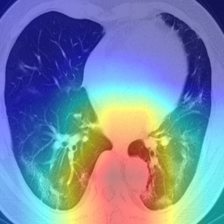

In [44]:
covid = Image.open(root_dir + 'Covid_Test/1_CT_COVID/PIIS0140673620301549_0_0.png')
covid_cam = show_gradCAM(model, covid)
covid_cam